Data Successfully Loaded in: 3.36 seconds


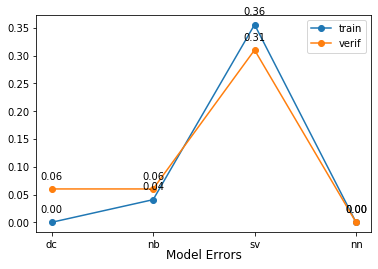

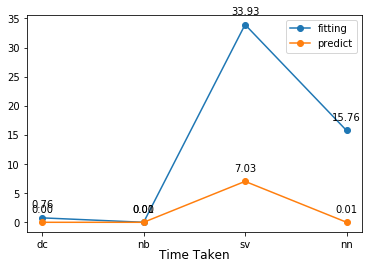

In [10]:
from google.colab import files
from time       import time
from io         import StringIO
from requests   import get

import matplotlib.pyplot as plt 
import pandas as pd
import numpy  as np 

from scipy.sparse import csr_matrix

from sklearn.base           import ClassifierMixin
from sklearn.tree           import DecisionTreeClassifier
from sklearn.naive_bayes    import MultinomialNB
from sklearn.svm            import SVC
from sklearn.neural_network import MLPClassifier


DIR = 'https://raw.githubusercontent.com/MilesMoran/Data-Mining-Final-Project/master/Task%201%20Source%20Files/'
MATRIX_URLS = {'train': DIR+'training.txt',
               'verif': DIR+'verification.csv',
               'test' : DIR+'testing.txt'}
LABELS_URLS = {'train': DIR+'label_training.txt',
               'verif': DIR+'label_verification.csv'}

################################################################################
def main() -> None:
    """
    Loads data into two dictionaries containing the tables and their labels. 
    Loops through the given classifiers and uses subroutines to get metrics for
    each classifier, including error rates and time taken to fit and predict. 
    Sends these metrics to another subroutine for plotting. 
    """
    (matrix, labels) = load_data()

    CLF_NAMES = ('dc', 'nb', 'sv', 'nn')

    errors = {'train': [], 'verif': []}
    timing = {'fitting': [], 'predict': []}
    for CLF_NAME in CLF_NAMES:
        (clf, time_fit) = get_fitted_model(CLF_NAME, matrix, labels)
        time_predict = classify_test_data(clf, CLF_NAME, matrix, download=False)

        train_error = 1 - clf.score(matrix['train'], labels['train'])
        verif_error = 1 - clf.score(matrix['verif'], labels['verif'])
        
        errors['train'].append(train_error)
        errors['verif'].append(verif_error)
        
        timing['fitting'].append(time_fit)
        timing['predict'].append(time_predict)

    plot_results(CLF_NAMES, errors, name="Model Errors")
    plot_results(CLF_NAMES, timing, name="Time Taken")
    return 

############################################################################
def load_data() -> tuple:
    """
    Loops through each Github URL to get the respective matrices and labels stored
    at each URL. Checks to make sure all of their shapes are correct before returning
    the matrices and labels as packaged in a dictionary. 

    Returns:
        matrix  (dict): Dictionary containing the training, verification, and testing matrices
        labels  (dict): Dictionary containing the training and verification labels

    """
    t1 = time()

    matrix = {'train': None, 'verif': None, 'test': None}
    labels = {'train': None, 'verif': None}
    for k in list(matrix.keys()):
        matrix[k] = get_csr_matrix(MATRIX_URLS[k])
    for k in list(labels.keys()):
        labels[k] = get_lbl_series(LABELS_URLS[k])

    # Make sure that there is a label for each object in the training and verification datasets
    # Make sure that the training and verification datasets have the same number of attributes (this assertion fails for the given datasets)
    assert labels['train'].shape[0] == matrix['train'].shape[0]
    assert labels['verif'].shape[0] == matrix['verif'].shape[0]
    assert matrix['train'].shape[1] == matrix['verif'].shape[1]

    t2 = time()
    print('Data Successfully Loaded in: {0:.2f} seconds'.format(t2-t1))
    return (matrix, labels)

################################################################################
def get_csr_matrix(URL: str) -> csr_matrix:
    """
    Use pandas.read_csv() to get the DataFrame of the table stored at the given URL.
    Transform that DataFrame into a SciPy CSR Matrix and return it. Checks to see 
    if the URL given is for the verification data; if so, reshape to correct dims.
    Note that the rows and columns of the final CSR matrix must be reindexed in 
    order to avoid off-by-one errors (b/c the original document indexed starting at 1) 

    Parameters:
        URL (str) : The Github URL of the desired table
    Returns:
        s   (csr_matrix): The pandas dataframe converted into a CSR matrix
    """
    DELIM = '\s+|,'
    DTYPE = {0: np.uint32, 1: np.uint32, 2: np.float64}

    content = StringIO(get(URL).content.decode('ASCII'))
    df = pd.read_csv(content, delimiter=DELIM, dtype=DTYPE, header=None, engine='python') 

    if URL == DIR+'verification.csv':
        df = df.append({0: 1, 1: 26364, 2: 0}, ignore_index=True)
    else: pass

    rows = df[0]-1
    cols = df[1]-1
    vals = df[2]
    s = csr_matrix((vals, (rows, cols)))
    return s

################################################################################
def get_lbl_series(URL: str) -> pd.Series:
    """
    Use pandas.read_csv() to return the Series of the labels stored at the given URL
    """
    DELIM = '\s+|,'
    DTYPE = np.int8

    content = StringIO(get(URL).content.decode('ASCII'))
    df = pd.read_csv(content, delimiter=DELIM, dtype=DTYPE, header=None, engine='python') 
    return df[0]

################################################################################
def get_fitted_model(name: str, matrix: dict, labels: dict) -> tuple:
    """
    Parameters:
        name    (str) : Name of the classifier to use
        matrix  (dict): Dictionary containing the training, verification, and testing matrices
        labels  (dict): Dictionary containing the training and verification labels
    Returns: 
        fitted_model (ClassifierMixin): The classifier fitted to the training data
        t       (float): Time taken to fit (train) the model
    """
    if name == 'dc':
        clf = DecisionTreeClassifier(max_leaf_nodes=None)
    elif name == 'nb':
        clf = MultinomialNB()
    elif name == 'sv':
        clf = SVC(C = 0.01, kernel='rbf', gamma='scale', probability=True)
    elif name == 'nn':
        clf = MLPClassifier(solver='adam', alpha=.001, hidden_layer_sizes=(15,))
    else:
        raise Exception('Name {} not recognized. Please enter one of {{dc, nb, sv, nn}}'.format(name))

    t1 = time()
    fitted_model = clf.fit(matrix['train'], labels['train'])
    t = time()-t1

    return (fitted_model, t)

################################################################################
def classify_test_data(clf: ClassifierMixin, clf_name: str, matrix: dict, download: bool) -> float:
    """
    Predict Labels for the Test Data given a specific Classifier. If verbose=True,
    the predicted labels will be downloaded as a .csv file and be printed along
    with the certainty assumed by the classifier
        
    Parameters:
        clf     (ClassifierMixing): Classifier used to predict test labels
        matrix  (dict): Dictionary containing the training, verification, and testing matrices
        verbose (bool): Whether or not to PRINT the predicted labels
    Returns: 
        t       (float): Time taken to predict the labels 
    """
    t1 = time() 
    test_lbls_predicted = clf.predict(matrix['test'])   
    P = clf.predict_proba(matrix['test'])
    t = time()-t1

    if download:
        output = pd.DataFrame(test_lbls_predicted)
        filename = "predicted_test_labels_{}.csv".format(clf_name)
        output.to_csv(filename, header=False, index=False)
        files.download(filename) 

    return t

################################################################################
def plot_results(CLF_NAMES: tuple, results: dict, name: str) -> None:
    """
    Plots two results at a time (y) against the names of the classifiers (x)
    """

    for res in results.keys(): 
        plt.plot(CLF_NAMES, results[res], 'o-', label=res)

        for (x, y) in zip(CLF_NAMES, results[res]):
            label = "{:.2f}".format(y)
            plt.annotate(label, (x, y), textcoords="offset points", xytext=(0,10), ha='center')
    
    plt.title(name, y=-.15)
    plt.legend()
    plt.show()
    return

################################################################################


main()